In [34]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

Firstly important thing is  to compare the differences between 5 classes classification problem and 3 classes one. Since the differences between severity levels are not so meaningfull.

### Data exploration

In [35]:
test_path = 'D:/semestr_10/master_thesis/medical_chatbot/data/images/test'
train_path = 'D:/semestr_10/master_thesis/medical_chatbot/data/images/train'
val_path = 'D:/semestr_10/master_thesis/medical_chatbot/data/images/val'

list_of_classes = ['Health', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

In [36]:
def load_dataset_info(path, list_of_classes):
    filepaths = []
    labels = []
    
    class_folders = sorted(os.listdir(path))  # assumes folders are named 0, 1, 2, etc.

    for klass in class_folders:
        try:
            intklass = int(klass)
            label = list_of_classes[intklass]
        except (ValueError, IndexError):
            print(f"Skipping folder: {klass} (not a valid class index)")
            continue

        class_path = os.path.join(path, klass)
        for f in os.listdir(class_path):
            fpath = os.path.join(class_path, f)
            if os.path.isfile(fpath):
                filepaths.append(fpath)
                labels.append(label)

    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

train_df = load_dataset_info(train_path, list_of_classes)
valid_df = load_dataset_info(val_path, list_of_classes)
test_df  = load_dataset_info(test_path, list_of_classes)

print(f'train_df length: {len(train_df)}, test_df length: {len(test_df)}, valid_df length: {len(valid_df)}')

classes = sorted(train_df['labels'].unique())
class_count = len(classes)
print(f'The number of classes in the dataset is: {class_count}')

groups = train_df.groupby('labels')
print(f'{"CLASS":^30s} {"IMAGE COUNT":^13s}')
countlist = []
classlist = []

for label in classes:
    group = groups.get_group(label)
    count = len(group)
    countlist.append(count)
    classlist.append(label)
    print(f'{label:^30s} {str(count):^13s}')

# Min/Max class info
max_value = np.max(countlist)
max_index = countlist.index(max_value)
max_class = classlist[max_index]

min_value = np.min(countlist)
min_index = countlist.index(min_value)
min_class = classlist[min_index]

print(f'{max_class} has the most images = {max_value}, {min_class} has the least images = {min_value}')

# Estimate average image shape
ht = 0
wt = 0
sample_size = min(100, len(train_df))
train_df_sample = train_df.sample(n=sample_size, random_state=123)

for i in range(sample_size):
    fpath = train_df_sample.iloc[i]['filepaths']
    try:
        with Image.open(fpath) as img:
            shape = img.size  # (width, height)
            wt += shape[0]
            ht += shape[1]
    except Exception as e:
        print(f"Skipping unreadable file: {fpath}, error: {e}")

avg_height = ht // sample_size
avg_width = wt // sample_size
aspect_ratio = round(ht / wt, 2) if wt != 0 else 'undefined'

print(f'Average height = {avg_height}, average width = {avg_width}, aspect ratio = {aspect_ratio}')

train_df length: 5778, test_df length: 1656, valid_df length: 826
The number of classes in the dataset is: 5
            CLASS               IMAGE COUNT 
           Doubtful                1046     
            Health                 2286     
           Minimal                 1516     
           Moderate                 757     
            Severe                  173     
Health has the most images = 2286, Severe has the least images = 173
Average height = 224, average width = 224, aspect ratio = 1.0


In [37]:
min_samples_per_class = train_df['labels'].value_counts().min()

train_5classes_df = (
    train_df.groupby('labels')
    .apply(
        lambda x: x.sample(n=200, random_state=42) if len(x) >= 200 else x.sample(n=200, replace=True, random_state=42)
        if x.name != 'Severe' else x
    )
    .reset_index(drop=True)
)

print(train_5classes_df['labels'].value_counts())

labels
Doubtful    200
Health      200
Minimal     200
Moderate    200
Severe      173
Name: count, dtype: int64


C:\Users\micha\AppData\Local\Temp\ipykernel_13044\3459420496.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [38]:
label_map = {
    'Health': 'Healthy',
    'Doubtful': 'Minimal',
    'Minimal': 'Minimal',
    'Moderate': 'Advanced',
    'Severe': 'Advanced'
}

train_df['labels'] = train_df['labels'].map(label_map)

train_3classes_df = (
    train_df.groupby('labels')
    .apply(lambda x: x.sample(n=200, random_state=42))
    .reset_index(drop=True)
)

print(train_3classes_df['labels'].value_counts())

labels
Advanced    200
Healthy     200
Minimal     200
Name: count, dtype: int64


C:\Users\micha\AppData\Local\Temp\ipykernel_13044\346097095.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=200, random_state=42))


In [43]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

# For 3-class classification
train_gen_3 = train_datagen.flow_from_dataframe(
    train_3classes_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    augmentation=True,
    shuffle=True,
    seed=42
)

val_gen_3 = train_datagen.flow_from_dataframe(
    train_3classes_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    augmentation=True,
    shuffle=False,
    seed=42
)

Found 480 validated image filenames belonging to 3 classes.


Found 120 validated image filenames belonging to 3 classes.


In [44]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = True  # freeze base model layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

In [45]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_gen_3,
    validation_data=val_gen_3,
    epochs=10,
    verbose=1
)

d:\semestr_10\master_thesis\medical_chatbot\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 329s 18s/step - accuracy: 0.4462 - loss: 1.1305 - val_accuracy: 0.0250 - val_loss: 1.6600
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 282s 19s/step - accuracy: 0.8596 - loss: 0.4680 - val_accuracy: 0.1333 - val_loss: 1.6679
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 322s 21s/step - accuracy: 0.9426 - loss: 0.2192 - val_accuracy: 0.2333 - val_loss: 1.4654
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 337s 22s/step - accuracy: 0.9963 - loss: 0.0699 - val_accuracy: 0.2917 - val_loss: 1.5602
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 504s 34s/step - accuracy: 0.9978 - loss: 0.0289 - val_accuracy: 0.3083 - val_loss: 1.7902
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 454s 26s/step - accuracy: 0.9969 - loss: 0.0223 - val_accuracy: 0.3417 - val_loss: 1.7105
Epoch 7/10
12/15 ━━━━━━━━━━━━━━━━━━━━ 1:34 31s/step - accuracy: 1.0000 - loss: 0.0098

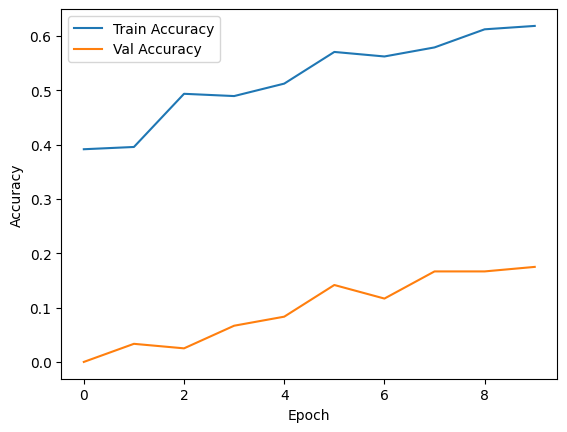

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

# For 5-class classification
train_gen_5 = train_datagen.flow_from_dataframe(
    train_5classes_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    augmentation=True,
    seed=42
)

val_gen_5 = train_datagen.flow_from_dataframe(
    train_5classes_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    augmentation=True,
    seed=42
)

Found 779 validated image filenames belonging to 5 classes.
Found 194 validated image filenames belonging to 5 classes.


In [ ]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = True

model5 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

In [ ]:
model5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
print(train_5classes_df['labels'].unique())
print("Train samples:", train_gen_5.samples)
print("Val samples:", val_gen_5.samples)

x_val_batch, y_val_batch = next(val_gen_5)
print("x_val shape:", x_val_batch.shape)
print("y_val shape:", y_val_batch.shape)
print("y_val[0]:", y_val_batch[0])

['Doubtful' 'Health' 'Minimal' 'Moderate' 'Severe']
Train samples: 779
Val samples: 194
x_val shape: (32, 224, 224, 3)
y_val shape: (32, 5)
y_val[0]: [1. 0. 0. 0. 0.]


In [ ]:
history5 = model5.fit(
    train_gen_5,
    validation_data=val_gen_5,
    epochs=10,
    verbose=1
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 149s 6s/step - accuracy: 0.2312 - loss: 2.0177 - val_accuracy: 0.0000e+00 - val_loss: 3.7933
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 153s 6s/step - accuracy: 0.2869 - loss: 1.5055 - val_accuracy: 0.0000e+00 - val_loss: 3.9934
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 148s 6s/step - accuracy: 0.3931 - loss: 1.3242 - val_accuracy: 0.0000e+00 - val_loss: 4.3254
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 122s 5s/step - accuracy: 0.4643 - loss: 1.2514 - val_accuracy: 0.0000e+00 - val_loss: 4.1293
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 135s 5s/step - accuracy: 0.4602 - loss: 1.2011 - val_accuracy: 0.0000e+00 - val_loss: 4.1406
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 133s 5s/step - accuracy: 0.4646 - loss: 1.1556 - val_accuracy: 0.0000e+00 - val_loss: 4.0904
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.5359 - loss: 1.1073 - val_accuracy: 0.0000e+00 - val_loss: 4.2135
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - accuracy: 0.5387 - loss: 1.072

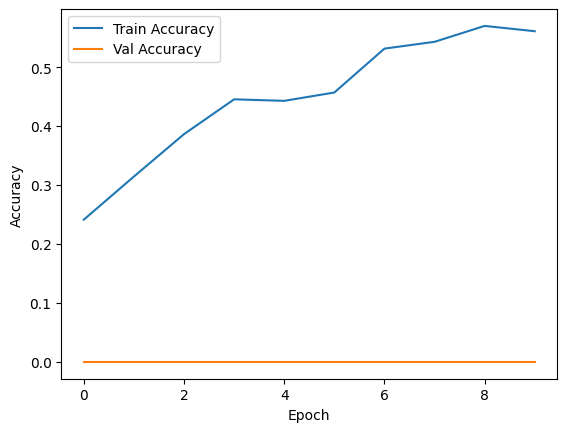

In [ ]:
plt.plot(history5.history['accuracy'], label='Train Accuracy')
plt.plot(history5.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()